<font size="6">**3. Remove the Dropout Module and Check the Result Changes**</font>

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/portia/Documents/AAA-College/AI/ai4astro', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/portia/Documents/AAA-College/AI/ai4astro', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(self.conv2(x), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def get_conv1_output(self, x):
        x = self.conv1(x)
        return x

    def get_conv2_output(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/Users/portia/Documents/AAA-College/AI/ai4astro/results/model.pth')
      torch.save(optimizer.state_dict(), '/Users/portia/Documents/AAA-College/AI/ai4astro/results/optimizer.pth')

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/Users/portia/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3061, Accuracy: 1442/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297812
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.061129
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.649192
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.086610
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.713493
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.495555
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.620749
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.355613
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.494406
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.678987
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.392826
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.350444
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.559231
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.326756
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.258644
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.397980
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.420227
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.358199
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.557186
Train Epoch: 1 [12160

In [13]:
def plot_conv_outputs(data):
    conv1_output = network.get_conv1_output(data)
    conv2_output = network.get_conv2_output(data)

    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        axes[i].imshow(conv1_output[0, i].detach().cpu(), cmap='gray')
        axes[i].set_title(f'Conv1 Channel {i}')
        axes[i].axis('off')
    plt.show()

    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        axes[i].imshow(conv2_output[0, i].detach().cpu(), cmap='gray')
        axes[i].set_title(f'Conv2 Channel {i}')
        axes[i].axis('off')
    plt.show()

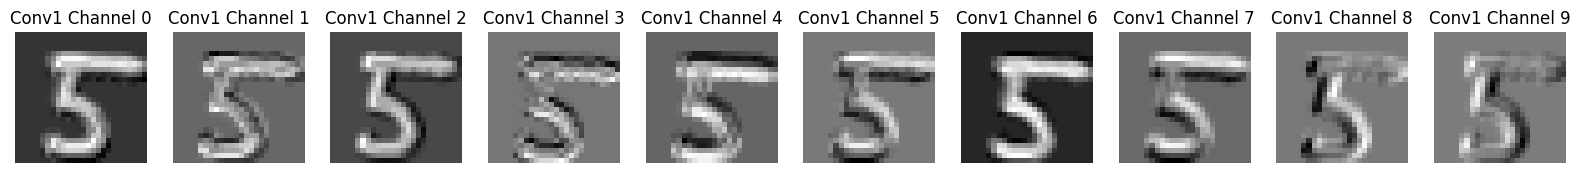

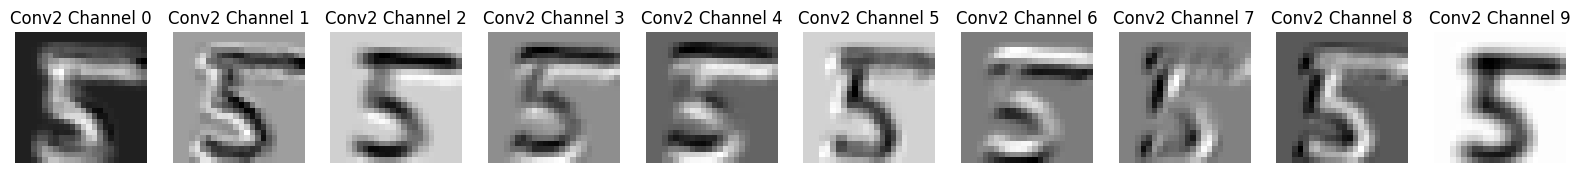

In [14]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))
plot_conv_outputs(example_data)

Text(0, 0.5, 'negative log likelihood loss')

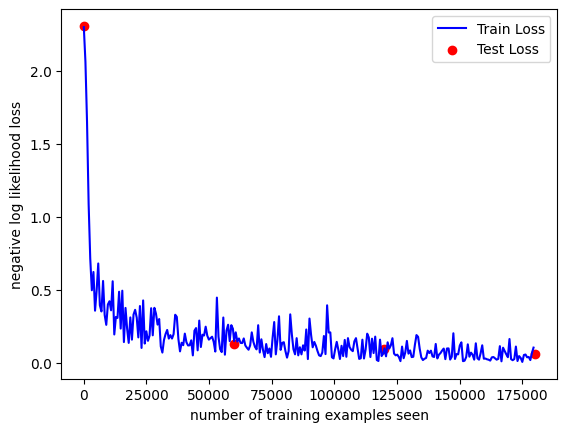

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')